# Upscaling of Sentinel-3 LST data using NDVI

## Author: Khizer Zakir

In this paper [An assessment on the relationship between land surface temperature and normalized difference vegetation index](!https://link.springer.com/article/10.1007/s10668-020-00657-6), the authors discuss the negative correlation between Land Surface Temperature (LST) and Normalized Difference Vegetation Index (NDVI) values. This suggests that the location - cells with high NDVI valeus will potentially have lower LST and vice versa. 

LST is an important factor or parameter for our used case to find the Open Waste Burning Sites (OWBS) or just the Open Waste Sites (OWS). "Land surface temperature is considered as an important parameter in analysing the exchange of composed material, energy balance and biophysical and chemical processes of the land surface (Tomlinson et al. 2011; Hao et al. 2016)". The assessment of the authors in the paper about the correlation between LST and NDVI and a detailed [tutorial](!https://towardsdatascience.com/downscaling-a-satellite-thermal-image-from-1000-m-to-10-m-python-3b2ed19ff103) about the rescaling/sharpening of a 1000 m LST to 10 m using NDVI values exploiting the correlation concept as discussed in the mentioned paper by Guha and Govil, helped us develop the following script. 

The main objective is to overcome the challenge of low resolution satellite imagery available to extract the LST values. 

In [3]:
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import rasterio
import geopandas as gpd
from pyproj import Transformer
from rasterio.plot import show, show_hist
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import shapes
import rasterstats
from scipy.stats import linregress



In [7]:
# set working directory
import os
os.chdir(r'D:\ERASMUS\France_Sem3\side projects\APAD_oxford\LST\1000_10m')

# check if working directory exists print exists
if os.path.exists(os.getcwd()):
    print("Directory Exists")


Directory Exists


In [9]:
# reprojection of the Sentinel-3 L2 LST data to EPSG:32643 (WGS 84 / UTM zone 43N) similar to the sentinel-2 data

# in this whole project you just need to make sure you get your I/O paths right and the CRS right

input_raster = 'subset_S3A_SL_2_LST____20231031T165315_20231031T165615_20231031T174845_0180_105_112_0360_PS1_O_NR_004_LST.tif'
output_raster = 'Sentinel-3_L2_LST_20231031_reproj_32643.tif'
dst_crs = 'EPSG:32643'

# Read the input raster file
with rasterio.open(input_raster) as src:
    # Get the transform, width, and height for the destination CRS
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)

    # Set up the destination
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'dtype': np.float32,
    })

    # Create the destination and write the reprojected data
    with rasterio.open(output_raster, 'w', **kwargs) as dst:
        # Perform the reprojection
        for i in range(1, src.count + 1):
            reproject(
                source=src.read(1).astype(np.float32)* src.scales[0] + src.offsets[0],
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.bilinear)

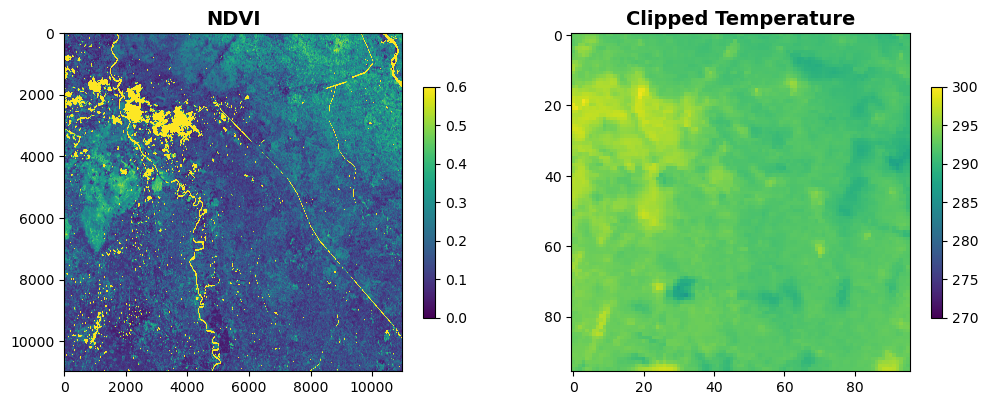

In [16]:
# Read the reprojected raster file and plot it
# side note: the reprojected raster is in the same projection as the sentinel-2 data and you can use arcgis or qgis to clip the raster to the same extent as the sentinel-2 data

# File paths
red_path = 'T43RGM_20231031T052949_B04_10m.jp2'
nir_path = 'T43RGM_20231031T052949_B08_10m.jp2'

clipped_temperature_path = 's3_clip_20231031.tif'

# Read raster data
with rasterio.open(red_path) as red_src:
  red = red_src.read(1)

with rasterio.open(nir_path) as nir_src:
  nir = nir_src.read(1)

with rasterio.open(clipped_temperature_path) as clipped_temp_ds:
  clipped_temperature = clipped_temp_ds.read(1)

# Calculate NDVI
ndvi = (nir - red) / (nir + red)

# Plot NDVI and temperature side by side
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Plot NDVI
im1 = ax1.imshow(ndvi, cmap='viridis', vmin=0, vmax=0.6)
ax1.set_title('NDVI', fontweight='bold', fontsize=14)
fig.colorbar(im1, ax=ax1, shrink=0.5)

# Plot clipped temperature
im2 = ax2.imshow(clipped_temperature, cmap='viridis', vmin=270, vmax=300) # you have to take care of this vmin and vmax values
ax2.set_title('Clipped Temperature', fontweight='bold', fontsize=14)
fig.colorbar(im2, ax=ax2, shrink=0.5)
plt.show()


In [17]:
# Create a mask for the NDVI values using the clipped temperature raster

mask = None

# Open the input raster
with rasterio.open(clipped_temperature_path) as src:
    # Read the raster band
    image = src.read(1).astype(np.float32)* src.scales[0] + src.offsets[0]
    results = (
        {'properties': {'Temperature': v}, 'geometry': s}
        for i, (s, v)
        in enumerate(
            shapes(image, mask=mask, transform=src.transform)))
    geoms = list(results)
    gpd_polygonized_raster  = gpd.GeoDataFrame.from_features(geoms)



# Open the rasters
with rasterio.open(nir_path) as nir_src:
  with rasterio.open(red_path) as red_src:

        # Read the data as float32
        nir = nir_src.read(1).astype(np.float32)* nir_src.scales[0] + nir_src.offsets[0]
        red = red_src.read(1).astype(np.float32)* red_src.scales[0] + red_src.offsets[0]

        # Calculate NDVI
        ndvi = (nir - red) / (nir + red)

        # Calculate the zonal statistics for each polygon
        stats = rasterstats.zonal_stats(gpd_polygonized_raster.geometry, ndvi, affine=nir_src.transform, stats='mean')

        # Add the mean value of NDVI to the dataframe
        gpd_polygonized_raster['NDVI'] = [s['mean'] for s in stats]

# Save the polygon layer to a shapefile
gpd_polygonized_raster.to_file('output_polygons_20231031.shp')

# Create a pandas dataframe from the geodataframe
stats_df = pd.DataFrame(gpd_polygonized_raster.drop(columns='geometry'))

# Print the dataframe
print(stats_df)

C:\Users\Khizer Zakir\AppData\Local\Temp\ipykernel_22916\549071001.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gpd_polygonized_raster.to_file('output_polygons_20231031.shp')


      Temperature      NDVI
0      292.744659  0.159105
1      292.862823  0.113660
2      293.055389  0.140841
3      293.436249  0.186016
4      293.723480  0.149119
...           ...       ...
9102   296.687073  0.115060
9103   295.644989  0.129297
9104   293.818756  0.202574
9105   292.732635  0.166676
9106   292.638641  0.109358

[9107 rows x 2 columns]


In [12]:
# Drop rows with NaN values, if there are any

df_clean = stats_df.dropna(subset=['NDVI'])
df_clean

,Temperature,NDVI
0,292.744659,0.159105
1,292.862823,0.113660
2,293.055389,0.140841
3,293.436249,0.186016
4,293.723480,0.149119
...,...,...
9102,296.687073,0.115060
9103,295.644989,0.129297
9104,293.818756,0.202574
9105,292.732635,0.166676


C:\Users\Khizer Zakir\AppData\Local\Temp\ipykernel_22916\487961571.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='NDVI', y='Temperature', data=df_clean, palette='coolwarm')


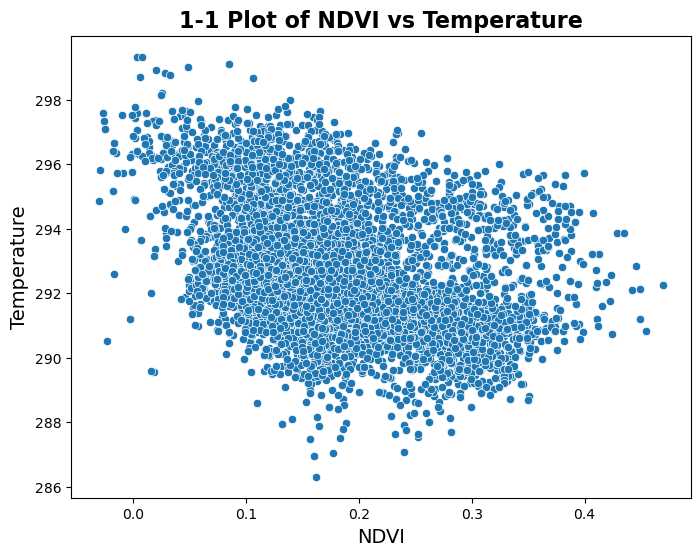

In [13]:

# Create a scatter plot 
plt.figure(figsize=(8, 6))
sns.scatterplot(x='NDVI', y='Temperature', data=df_clean, palette='coolwarm')


# Set plot title and axis labels
plt.title('1-1 Plot of NDVI vs Temperature', fontsize=16, fontweight='bold')
plt.xlabel('NDVI', fontsize=14)
plt.ylabel('Temperature', fontsize=14)

# Show the plot
plt.show()

### Important pointer

In our case, we do not see many outliers; however it is essential that clean the data before applying the regression. Just need to apply a filter looking at the scatter plot. 

C:\Users\Khizer Zakir\AppData\Local\Temp\ipykernel_22916\3231525406.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='NDVI', y='Temperature', data=df_clean, palette='coolwarm')


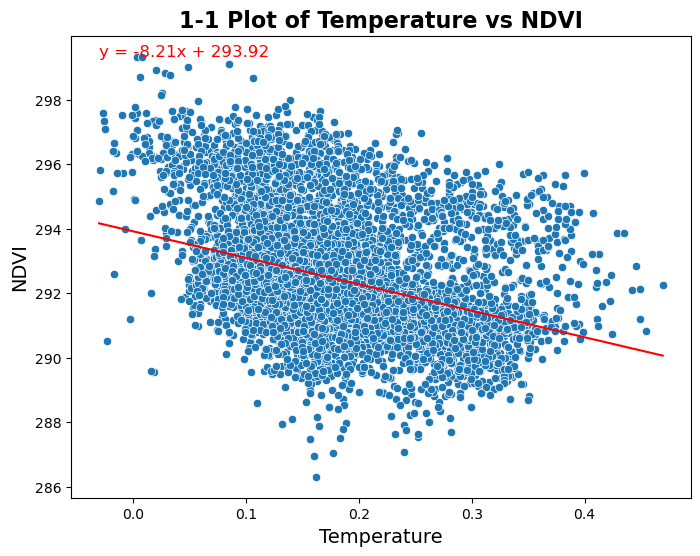

In [14]:
# Create a scatter plot of Temperature versus NDVI
plt.figure(figsize=(8, 6))
sns.scatterplot(x='NDVI', y='Temperature', data=df_clean, palette='coolwarm')


# Fit a linear regression model
slope, intercept = np.polyfit(df_clean['NDVI'], df_clean['Temperature'], 1)

# Plot the fitted line
x_line = np.linspace(min(df_clean['NDVI']), max(df_clean['NDVI']), 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'r', label='Fitted line')

# Create the equation string
equation_str = f'y = {slope:.2f}x + {intercept:.2f}'

# Display the equation on the plot
plt.text(min(df_clean['NDVI']), max(df_clean['Temperature']), equation_str, fontsize=12, color='red')


# Set plot title and axis labels
plt.title('1-1 Plot of Temperature vs NDVI', fontsize=16, fontweight='bold')
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('NDVI', fontsize=14)

# Show the plot
plt.show()

### Interpretation

We will use the slope and intercept value to estimate the values for the LST and make a sharpened version of the temperature raster layer for our use. 

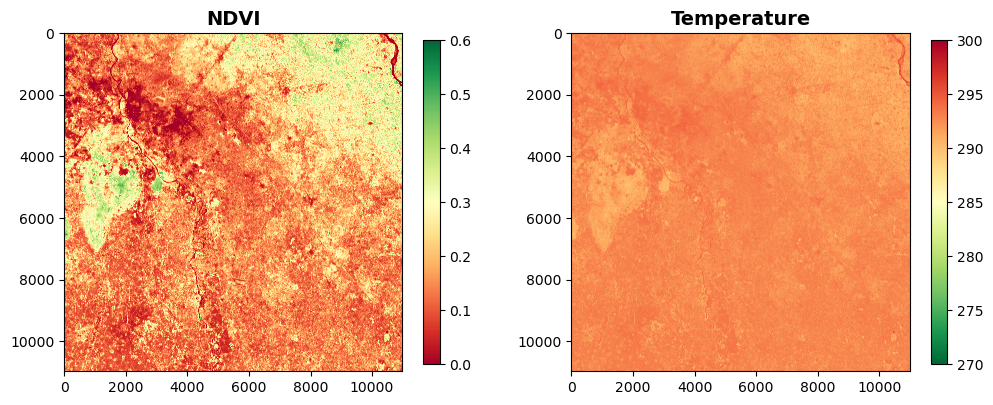

In [18]:


# Estimate temperature using NDVI
temp = -8.21 * ndvi + 293.92

# Create a color ramp for NDVI
ndvi_cmap = plt.cm.RdYlGn

# Plot NDVI and temperature side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Plot NDVI
im1 = ax1.imshow(ndvi, cmap=ndvi_cmap, vmin=0, vmax=0.6)
ax1.set_title('NDVI', fontweight='bold', fontsize=14)
fig.colorbar(im1, ax=ax1, shrink=0.7)

# Plot temperature
im2 = ax2.imshow(temp, cmap=ndvi_cmap.reversed(), vmin=270, vmax=300) # you have to take care of this vmin and vmax values
ax2.set_title('Temperature', fontweight='bold', fontsize=14)
fig.colorbar(im2, ax=ax2, shrink=0.7)

plt.show()


In [19]:

# export the temperature raster
with rasterio.open(clipped_temperature_path) as src:
    # Get the metadata of the source raster
    meta = src.meta.copy()

    # Update the metadata
    meta.update({
        'dtype': 'float32',
        'nodata': None
    })

    # Write the temperature raster to a new file
    with rasterio.open('temperature_20231031.tif', 'w', **meta) as dst:
        dst.write(temp.astype(np.float32), 1)
        print('Temperature raster exported successfully')

# close the raster files
src.close()

Temperature raster exported successfully


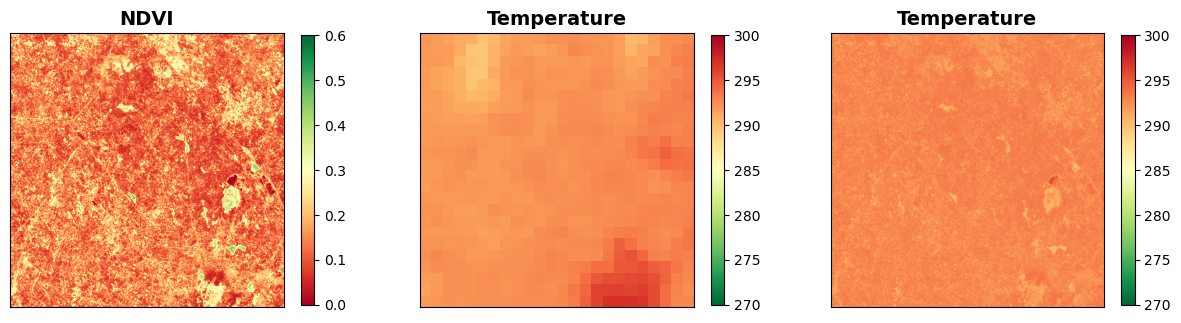

In [20]:
# Plot NDVI and temperature side by side
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

# Plot NDVI
vmin, vmax = 0, 0.6
ndvi_subset = ndvi[int(0.75 * ndvi.shape[0]):, int(0.75 * ndvi.shape[1]):]
im1 = axs[0].imshow(ndvi_subset, cmap=ndvi_cmap, vmin=vmin, vmax=vmax)
axs[0].set_title('NDVI', fontweight='bold', fontsize=14)
axs[0].set_xticks([])
axs[0].set_yticks([])
fig.colorbar(im1, ax=axs[0], shrink=0.7)


vmin, vmax = 270, 300
temp_subset = clipped_temperature[int(0.75 * clipped_temperature.shape[0]):, int(0.75 * clipped_temperature.shape[1]):]
im3 = axs[1].imshow(temp_subset, cmap=ndvi_cmap.reversed(), vmin=vmin, vmax=vmax)
axs[1].set_title('Temperature', fontweight='bold', fontsize=14)
axs[1].set_xticks([])
axs[1].set_yticks([])
fig.colorbar(im3, ax=axs[1], shrink=0.7)



# Plot temperature
vmin, vmax = 270, 300
temp_subset = temp[int(0.75 * temp.shape[0]):, int(0.75 * temp.shape[1]):]
im2 = axs[2].imshow(temp_subset, cmap=ndvi_cmap.reversed(), vmin=vmin, vmax=vmax)
axs[2].set_title('Temperature', fontweight='bold', fontsize=14)
axs[2].set_xticks([])
axs[2].set_yticks([])
fig.colorbar(im2, ax=axs[2], shrink=0.7)

# Adjust the spacing between the subplots
fig.subplots_adjust(wspace=0.2)


plt.show()

# Conclusion

The last plot gives the fundamental idea behind the whole process that we were trying to achieve with all this. Sometimes a coarse-grained estimation for a physical process/value can hamper the process of making sound inferences. However, this heuristics to utilize the standing concept of NDVI-LST relationship comes as a sound technique to upscale the a 1000m LST raster layer to 10m . 